In [ ]:
# Para la Estrategia 2. Este es el modelo 3 de regresión para vehículos no premium < 70.000 euros

In [2]:
# Paso 1: Importar las bibliotecas necesarias

import numpy as np
import pandas as pd
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from sklearn.preprocessing import StandardScaler


In [3]:
# Paso 2: Carga de datos 

df = pd.read_csv("../data/feature_engineering.csv")



In [4]:
# Separar características y target antes del split
X = df.drop(columns="price")
y = df["price"]

In [5]:
# División
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Unir temporalmente para filtrar de forma coherente
train = pd.concat([X_train, y_train], axis=1)
test = pd.concat([X_test, y_test], axis=1)

# Filtro por precio < 70000 en cada conjunto
train = train[train["price"] < 70000]
test = test[test["price"] < 70000]

# Volver a separar
X_train = train.drop(columns="price")
y_train = train["price"]

X_test = test.drop(columns="price")
y_test = test["price"]

# Aplicar logaritmo natural + 1
y_train_log = np.log1p(y_train)
y_test_log = np.log1p(y_test)

In [6]:
# # Filtramos los datos para los vehículos de menos de 70000 euros, calificados no premium. 

# df = df[df["price"] < 70000]

In [7]:
# df

In [8]:
# # Transformación logarítmica

# # Aplica la transformación logarítmica
# cols_to_transform = ['price']
# df[cols_to_transform] = df[cols_to_transform].apply(np.log1p)

In [9]:
# df

In [10]:
# # Separar características (X) y variable objetivo (y)
# X = df.drop(columns="price")
# y_log = df["price"]

In [11]:
# # Dividir los datos en entrenamiento y prueba
# X_train, X_test, y_train_log, y_test_log = train_test_split(X, y_log, test_size=0.2, random_state=42)

In [12]:
# X_train = X_train[X_train["price"] < 70000]

In [13]:
# # Filtramos los datos para los vehículos de menos de 70000 euros, calificados no premium. 

# df = df[df["price"] < 70000]

XGBRegressor

In [14]:
# Definir modelo base
xgb_model = XGBRegressor(random_state=42)

# Hiperparámetros para GridSearch
param_grid = {
    "max_depth": [4, 5, 6],
    "n_estimators": [50,100,150],
    "learning_rate": [0.05,0.1,0.2]
}

# Grid search con validación cruzada
xgb_grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    cv=5,
    scoring="neg_mean_absolute_error",
    n_jobs=-1
)

# Entrenar modelo
xgb_grid_search.fit(X_train, y_train_log)

# Mejor modelo encontrado
best_xgb = xgb_grid_search.best_estimator_

# Predicciones
y_train_log_pred = best_xgb.predict(X_train)
y_test_log_pred = best_xgb.predict(X_test)


# Revertir la transformación logarítmica para evaluar en la escala original

y_train_pred = np.expm1(y_train_log_pred)
y_test_pred = np.expm1(y_test_log_pred)
y_train = np.expm1(y_train_log)
y_test = np.expm1(y_test_log)

# Métricas de evaluación en la escala original
mae_train_xgb = mean_absolute_error(y_train, y_train_pred)
mae_test_xgb = mean_absolute_error(y_test, y_test_pred)

# R² (en la escala original)
r2_train_xgb = r2_score(y_train, y_train_pred)
r2_test_xgb = r2_score(y_test, y_test_pred)

# Resultados
print("=== Evaluación del mejor modelo XGBoost ===")
print(f"Mejores hiperparámetros: {xgb_grid_search.best_params_}")
print(f"MAE en entrenamiento: {mae_train_xgb:.4f}")
print(f"MAE en prueba:        {mae_test_xgb:.4f}")
print(f"R² en entrenamiento: {r2_train_xgb:.4f}")
print(f"R² en prueba:        {r2_test_xgb:.4f}")

=== Evaluación del mejor modelo XGBoost ===
Mejores hiperparámetros: {'learning_rate': 0.2, 'max_depth': 6, 'n_estimators': 150}
MAE en entrenamiento: 1636.3186
MAE en prueba:        2328.0548
R² en entrenamiento: 0.9602
R² en prueba:        0.9118


Random Forest

In [15]:

# Definir el modelo base
rf_model = RandomForestRegressor(random_state=42)

# Espacio de búsqueda de hiperparámetros
param_grid = {
    "n_estimators": [50,100, 150],
    "max_depth": [10,12,13],
    # Puedes añadir más parámetros si los deseas:
    # "max_features": [8, 9, 10],
    # "max_leaf_nodes": [70, 100, 140]
}

# Configurar búsqueda en cuadrícula con validación cruzada
grid_search_rf = GridSearchCV(
    estimator=rf_model,
    param_grid=param_grid,
    cv=5,
    scoring="neg_mean_absolute_error",
    n_jobs=-1
)

# Entrenar el modelo con el conjunto de entrenamiento
grid_search_rf.fit(X_train, y_train_log)

# Mejor modelo encontrado
best_rf = grid_search_rf.best_estimator_

# Predicciones
y_train_log_pred = best_rf.predict(X_train)
y_test_log_pred = best_rf.predict(X_test)

# Revertir la transformación logarítmica para evaluar en la escala original

y_train_pred = np.expm1(y_train_log_pred)
y_test_pred = np.expm1(y_test_log_pred)
y_train = np.expm1(y_train_log)
y_test = np.expm1(y_test_log)


# Evaluación con MAE
mae_train_rf = mean_absolute_error(y_train, y_train_pred)
mae_test_rf = mean_absolute_error(y_test, y_test_pred)

# R² (en la escala original)
r2_train_rf = r2_score(y_train, y_train_pred)
r2_test_rf = r2_score(y_test, y_test_pred)

# Resultados
print("=== Evaluación del mejor modelo Random Forest ===")
print(f"Mejores hiperparámetros: {grid_search_rf.best_params_}")
print(f"MAE en entrenamiento: {mae_train_rf:.4f}")
print(f"MAE en prueba:        {mae_test_rf:.4f}")
print(f"R² en entrenamiento: {r2_train_rf:.4f}")
print(f"R² en prueba:        {r2_test_rf:.4f}")

=== Evaluación del mejor modelo Random Forest ===
Mejores hiperparámetros: {'max_depth': 13, 'n_estimators': 150}
MAE en entrenamiento: 1574.5096
MAE en prueba:        2464.7331
R² en entrenamiento: 0.9596
R² en prueba:        0.8979


=== Evaluación del mejor modelo CatBoost ===
Mejores hiperparámetros: {'depth': 10, 'iterations': 400, 'learning_rate': 0.2}
MAE en entrenamiento: 1245.4528
MAE en prueba:        2123.6649
R² en entrenamiento: 0.9771
R² en prueba:        0.9211


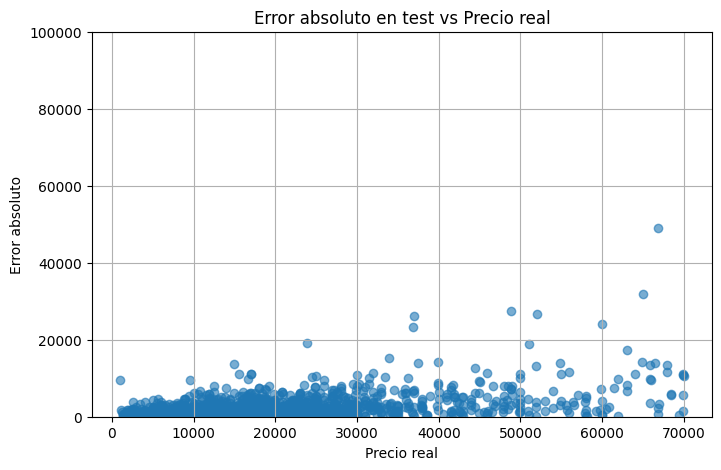

In [20]:
# Definir el modelo base
cat_model = CatBoostRegressor(random_state=42, verbose=0)

# Espacio de búsqueda de hiperparámetros
param_grid = {
    "depth": [6, 8,10],
    "learning_rate": [0.1, 0.2,0.4],
    "iterations": [200, 300,400]
}

# Configurar búsqueda en cuadrícula con validación cruzada
grid_search_cat = GridSearchCV(
    estimator=cat_model,
    param_grid=param_grid,
    cv=5,
    scoring="neg_mean_absolute_error",
    n_jobs=-1
)

# Entrenar el modelo con el conjunto de entrenamiento
grid_search_cat.fit(X_train, y_train_log)

# Mejor modelo encontrado
best_cat = grid_search_cat.best_estimator_

# Predicciones
y_train_log_pred = best_cat.predict(X_train)
y_test_log_pred = best_cat.predict(X_test)

# Revertir la transformación logarítmica para evaluar en la escala original

y_train_pred = np.expm1(y_train_log_pred)
y_test_pred = np.expm1(y_test_log_pred)
y_train = np.expm1(y_train_log)
y_test = np.expm1(y_test_log)

# Evaluación con MAE
mae_train_cat = mean_absolute_error(y_train, y_train_pred)
mae_test_cat = mean_absolute_error(y_test, y_test_pred)

# Evaluación con R²
r2_train_cat = r2_score(y_train, y_train_pred)
r2_test_cat = r2_score(y_test, y_test_pred)

# Resultados
print("=== Evaluación del mejor modelo CatBoost ===")
print(f"Mejores hiperparámetros: {grid_search_cat.best_params_}")
print(f"MAE en entrenamiento: {mae_train_cat:.4f}")
print(f"MAE en prueba:        {mae_test_cat:.4f}")
print(f"R² en entrenamiento: {r2_train_cat:.4f}")
print(f"R² en prueba:        {r2_test_cat:.4f}")


import matplotlib.pyplot as plt
import numpy as np

# Error absoluto por muestra
errors_abs = np.abs(y_test - y_test_pred)

plt.figure(figsize=(8,5))
plt.scatter(y_test, errors_abs, alpha=0.6)
plt.xlabel('Precio real')
plt.ylabel('Error absoluto')
plt.title('Error absoluto en test vs Precio real')
plt.ylim(0, 100000)  # Limitar eje Y
plt.grid(True)
plt.show()

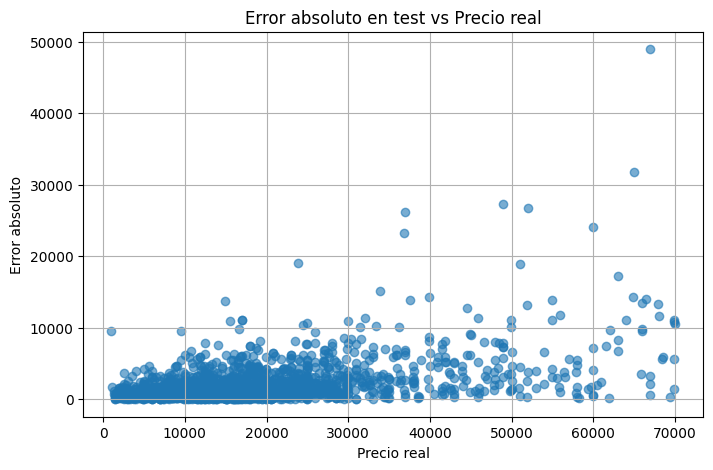

In [21]:
# Error absoluto por muestra
errors_abs = np.abs(y_test - y_test_pred)

plt.figure(figsize=(8,5))
plt.scatter(y_test, errors_abs, alpha=0.6)
plt.xlabel('Precio real')
plt.ylabel('Error absoluto')
plt.title('Error absoluto en test vs Precio real')
# plt.ylim(0, 100000)  # Limitar eje Y
plt.grid(True)
plt.show()

In [17]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error

# Definir el modelo base
gb_model = GradientBoostingRegressor(random_state=42)

# Espacio de búsqueda de hiperparámetros
param_grid = {
    "n_estimators": [50, 70, 100],
    "max_depth": [3, 5, 6],
    "learning_rate": [0.05, 0.1, 0.2]
}

# Configurar búsqueda en cuadrícula con validación cruzada
grid_search_gb = GridSearchCV(
    estimator=gb_model,
    param_grid=param_grid,
    cv=5,
    scoring="neg_mean_absolute_error",
    n_jobs=-1
)

# Entrenar el modelo con el conjunto de entrenamiento
grid_search_gb.fit(X_train, y_train_log)

# Mejor modelo encontrado
best_gb = grid_search_gb.best_estimator_

# Predicciones
y_train_log_pred = best_gb.predict(X_train)
y_test_log_pred = best_gb.predict(X_test)

# Revertir la transformación logarítmica para evaluar en la escala original

y_train_pred = np.expm1(y_train_log_pred)
y_test_pred = np.expm1(y_test_log_pred)
y_train = np.expm1(y_train_log)
y_test = np.expm1(y_test_log)

# Evaluación con MAE
mae_train_gb = mean_absolute_error(y_train, y_train_pred)
mae_test_gb = mean_absolute_error(y_test, y_test_pred)

# Evaluación con R²
r2_train_gb = r2_score(y_train, y_train_pred)
r2_test_gb = r2_score(y_test, y_test_pred)

# Resultados
print("=== Evaluación del mejor modelo Gradient Boosting ===")
print(f"Mejores hiperparámetros: {grid_search_gb.best_params_}")
print(f"MAE en entrenamiento: {mae_train_gb:.4f}")
print(f"MAE en prueba:        {mae_test_gb:.4f}")
print(f"R² en entrenamiento: {r2_train_gb:.4f}")
print(f"R² en prueba:        {r2_test_gb:.4f}")

=== Evaluación del mejor modelo Gradient Boosting ===
Mejores hiperparámetros: {'learning_rate': 0.2, 'max_depth': 6, 'n_estimators': 100}
MAE en entrenamiento: 1724.9335
MAE en prueba:        2362.2592
R² en entrenamiento: 0.9570
R² en prueba:        0.9086


In [18]:
# Crear tabla con los resultados
resultados_modelos = pd.DataFrame({
    "Modelo": ["Random Forest", "XGBoost", "CatBoost", "Gradient Boosting"],
    "MAE Train": [mae_train_rf, mae_train_xgb, mae_train_cat, mae_train_gb],
    "MAE Test": [mae_test_rf, mae_test_xgb, mae_test_cat, mae_test_gb],
    "R² Train": [r2_train_rf, r2_train_xgb, r2_train_cat, r2_train_gb],
    "R² Test": [r2_test_rf, r2_test_xgb, r2_test_cat, r2_test_gb]
})

# Mostrar tabla ordenada por mejor MAE en test
resultados_modelos = resultados_modelos.sort_values(by="MAE Test", ascending=True)

# Visualizar
print(resultados_modelos)

              Modelo    MAE Train     MAE Test  R² Train   R² Test
2           CatBoost  1245.452788  2123.664915  0.977111  0.921068
1            XGBoost  1636.318600  2328.054785  0.960242  0.911827
3  Gradient Boosting  1724.933469  2362.259180  0.957043  0.908574
0      Random Forest  1574.509559  2464.733100  0.959599  0.897934


In [19]:
# Vamos a guardar un modelo

from joblib import dump

# Guardamos el mejor modelo para los vehículos de menos de 70000 euros. En este caso Modelo CatBoost. Se ha trabajado con transformada logarítmica en target precio
dump(best_cat, "../model/Modelo3_regresion_cat_logY_split.pkl")
print("✅ Modelo de CatBoost con transformación logaritmica en target 'Modelo3_regresion_cat_logY.pkl'")


✅ Modelo de CatBoost con transformación logaritmica en target 'Modelo3_regresion_cat_logY.pkl'
